In [14]:
 !pip install langchain langchain_core langchain_community langchain_groq langgraph

In [2]:
from typing import TypedDict
from langgraph.graph import StateGraph,END
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.runnables.graph import MermaidDrawMethod

In [3]:
from re import S
class state(TypedDict):
  query:str
  category:str
  sentiment:str
  response:str

In [4]:
from langchain_groq import ChatGroq
llm = ChatGroq(
    temperature = 0,
    groq_api_key = "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",
    model_name ="llama-3.3-70b-versatile"
)
llm.invoke("What is large language?")

AIMessage(content='Large language models (LLMs) are a type of artificial intelligence (AI) designed to process and understand human language at a large scale. They are trained on vast amounts of text data, which enables them to learn patterns, relationships, and structures of language.\n\nLLMs are typically characterized by their ability to:\n\n1. **Process large amounts of text data**: They can handle massive datasets, often consisting of billions of words or more.\n2. **Learn from context**: They can understand the nuances of language, including grammar, syntax, semantics, and pragmatics.\n3. **Generate human-like text**: They can produce coherent and natural-sounding text, often indistinguishable from text written by humans.\n4. **Improve over time**: They can learn from feedback, adapt to new data, and refine their performance over time.\n\nSome key features of LLMs include:\n\n* **Tokenization**: breaking down text into individual words or tokens\n* **Embeddings**: representing wo

In [5]:
def categorize(state:state):
  "Technical ,Billing, General"
  prompt = ChatPromptTemplate.from_template(
      "Categorize the following customer query into one of these categorizes:"
      "Technical,Billing,General.Query:{query}"
  )
  chain = prompt | llm
  category = chain.invoke({"query":state["query"]}).content
  return {"query": state["query"], "category":category, "sentiment":"", "response":""} # Return empty strings instead of None

def analyze_sentiment(state:state):
  prompt = ChatPromptTemplate.from_template(
      "Analyze the sentiment of the following customer query"
      "Response with either 'Positive','Neutral' or 'Negative'.Query:{query} "
  )
  chain = prompt | llm
  sentiment = chain.invoke({"query":state["query"]}).content
  return {"query": state["query"], "category": state["category"], "sentiment" : sentiment, "response":state["response"]} # Pass through existing response

def handle_technical(state:state):
  prompt = ChatPromptTemplate.from_template(
      "Provide a technical support response to the following customer query.Query:{query}"
  )
  chain = prompt | llm
  response = chain.invoke({"query":state["query"]}).content
  return {"query": state["query"], "response":response, "category": state["category"], "sentiment": state["sentiment"]}

def handle_billing(state:state):
  prompt = ChatPromptTemplate.from_template(
      "Provide a billing support response to the following customer query.Query:{query}"
  )
  chain = prompt | llm
  response = chain.invoke({"query":state["query"]}).content
  return {"query": state["query"], "response":response, "category": state["category"], "sentiment": state["sentiment"]}

def handle_general(state:state):
  prompt = ChatPromptTemplate.from_template(
      "Provide a general support response to the following customer querry.Query:{query}"
  )
  chain = prompt | llm
  response = chain.invoke({"query" : state["query"]}).content
  return {"query": state["query"], "response" : response, "category": state["category"], "sentiment": state["sentiment"]}

def escalate(state:state):
  return {"query": state["query"], "response":"These query has been escalated to human agent due to its negative sentiment", "category": state["category"], "sentiment": state["sentiment"]}


def route_query(state:state):
  if state["sentiment"] == "Negative":
    return "escalate"
  elif state["category"] == "Technical":
    return "handle_technical"
  elif state["category"] == "Billing":
    return "handle_billing"
  else:
    return "handle_general"

In [6]:
workflow = StateGraph(state)

workflow.add_node("categorize", categorize)
workflow.add_node("analyze_sentiment", analyze_sentiment)
workflow.add_node("handle_technical", handle_technical)
workflow.add_node("handle_billing", handle_billing)
workflow.add_node("handle_general", handle_general)
workflow.add_node("escalate", escalate)

workflow.add_edge("categorize", "analyze_sentiment")
workflow.add_conditional_edges(
    "analyze_sentiment",
    route_query, {
        "handle_technical": "handle_technical",
        "handle_billing": "handle_billing",
        "handle_general": "handle_general",
        "escalate": "escalate"
        }
)
workflow.add_edge("handle_technical",END)
workflow.add_edge("handle_billing",END)
workflow.add_edge("handle_general",END)
workflow.add_edge("escalate",END)

workflow.set_entry_point("categorize")

app = workflow.compile()

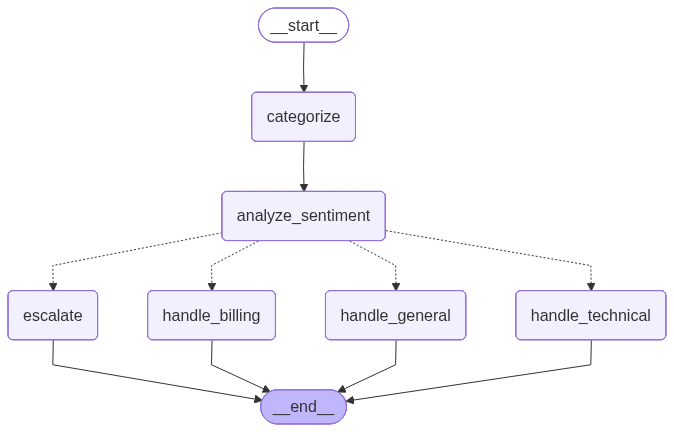

In [7]:
from IPython.display import Image
display(
    Image(
        app.get_graph().draw_mermaid_png(
            draw_method = MermaidDrawMethod.API
        )
    )
)

In [8]:
from typing import Dict

def run_customer_support(query:str)-> Dict[str,str]:
  results = app.invoke({"query":query})
  return {
      "category":results["category"],
      "sentiment":results["sentiment"],
      "response":results["response"]
  }

In [9]:
query = "My internet connection is very slow,Can you help me ?"
result = run_customer_support({"query" : query})
print(f"Query:{query}")
print(f"Category:{result['category']}")
print(f"Sentiment:{result['sentiment']}")
print(f"Response:{result['response']}")
print("\n")

Query:My internet connection is very slow,Can you help me ?
Category:The customer query can be categorized as: **Technical**

Reason: The query is related to a technical issue with the customer's internet connection, which is a common technical support topic. The customer is seeking help to resolve the slow internet connection issue, which requires technical assistance.
Sentiment:The sentiment of the customer query is: 'Negative'.

Reason: The customer is expressing dissatisfaction with their internet connection, stating that it is "very slow", which indicates a problem or issue that needs to be resolved. Although they are asking for help, the overall tone is negative due to the complaint about the slow connection.
Response:I'm so sorry to hear that you're experiencing a slow internet connection. I'd be happy to help you troubleshoot the issue.

To better assist you, could you please provide me with some more details? For example:

* What type of internet connection do you have (e.g. W

In [10]:
!pip install gradio

In [11]:
import gradio as gr

In [12]:
def gradio_interface(query:str):
  result = run_customer_support({"query" : query})
  return(
      f"Category:{result['category']}"
      f"Sentiment:{result['sentiment']}"
      f"Response:{result['response']}"
  )
  print("/n")


In [13]:
gui = gr.Interface(
    fn=gradio_interface,
    theme = 'Yntec/HaleyCH_Theme_Orange_Green',
    inputs  = gr.Textbox(label = "Enter your query "),
    outputs = gr.Markdown(),
    title   = "Customer Support Assistance",
    description = "Provide a query and recieve a categorical response.The system analyses the sentiment"
)

gui.launch()

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


theme_schema%400.0.1.json: 0.00B [00:00, ?B/s]

It looks like you are running Gradio on a hosted Jupyter notebook, which requires `share=True`. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://82aa8cfb593db8e7d7.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
